0. The goal of the project os to forecast Max temperature and if snow for Saint-Pierre et Miquelon

1.Install and Import Dependencies

In [1]:
#Install openmeteo API,...
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [2]:
!pip install neuralprophet plotly plotly-resampler tsdownsample

In [3]:
!pip install plotly-resampler
!pip install --upgrade plotly

In [ ]:
!pip install --upgrade neuralprophet

In [5]:
#Python Libraries
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt
import pickle

In [6]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [7]:
#SPM coordinates
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 46.7791,
	"longitude": -56.1773,
	"start_date": "2019-01-01",
	"end_date": "2024-12-04",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum"]
}
responses = openmeteo.weather_api(url, params=params)

In [8]:
# Process SPM location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_sunrise = daily.Variables(4).ValuesAsNumpy()
daily_sunset = daily.Variables(5).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(6).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(7).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(8).ValuesAsNumpy()
daily_rain_sum = daily.Variables(9).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(10).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)


Coordinates 46.78382873535156°N -56.122772216796875°E
Elevation 30.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                          date  weather_code  temperature_2m_max  \
0    2019-01-01 00:00:00+00:00          75.0              -0.145   
1    2019-01-02 00:00:00+00:00          75.0               2.705   
2    2019-01-03 00:00:00+00:00           3.0              -3.445   
3    2019-01-04 00:00:00+00:00           3.0              -0.495   
4    2019-01-05 00:00:00+00:00          73.0               2.605   
...                        ...           ...                 ...   
2160 2024-11-30 00:00:00+00:00          53.0               7.405   
2161 2024-12-01 00:00:00+00:00          75.0               5.755   
2162 2024-12-02 00:00:00+00:00          51.0               5.605   
2163 2024-12-03 00:00:00+00:00          71.0               5.005   
2164 2024-12-04 00:00:00+00:00          71.0               2.355   

      temperature_2m_min  temperature_2m_mean  sunrise  

2. Read in Data and Process Data

In [8]:
daily_dataframe.head()

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum
0,2019-01-01 00:00:00+00:00,75.0,-0.145,-5.045,-2.276250,0,0,31015.080078,0.000000,5.800000,0.0,4.130000
1,2019-01-02 00:00:00+00:00,75.0,2.705,-3.695,-0.705417,0,0,31072.484375,24013.644531,15.500003,0.7,10.359999
2,2019-01-03 00:00:00+00:00,3.0,-3.445,-5.495,-4.672084,0,0,31135.164062,16080.624023,0.000000,0.0,0.000000
3,2019-01-04 00:00:00+00:00,3.0,-0.495,-4.445,-2.774166,0,0,31202.960938,7237.602539,0.000000,0.0,0.000000
4,2019-01-05 00:00:00+00:00,73.0,2.605,-0.545,1.407083,0,0,31275.707031,0.000000,3.299999,1.0,1.610000


In [9]:
daily_dataframe.columns

Index(['date', 'weather_code', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'sunrise', 'sunset', 'daylight_duration',
       'sunshine_duration', 'precipitation_sum', 'rain_sum', 'snowfall_sum'],
      dtype='object')

In [18]:
daily_dataframe.dtypes

,0
date,"datetime64[ns, UTC]"
weather_code,float32
temperature_2m_max,float32
temperature_2m_min,float32
temperature_2m_mean,float32
sunrise,int64
sunset,int64
daylight_duration,float32
sunshine_duration,float32
precipitation_sum,float32


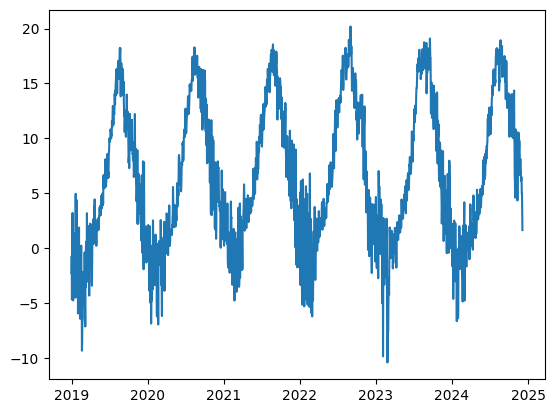

In [9]:
#PLot mean temperatures for SPM
plt.plot(daily_dataframe['date'], daily_dataframe['temperature_2m_mean'])

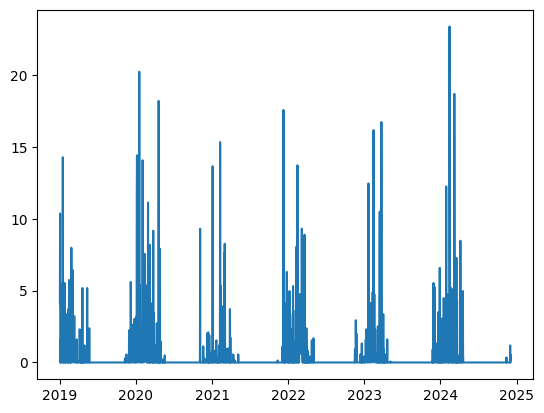

In [10]:
#Plot snowfall from 2019-2024
plt.plot(daily_dataframe['date'], daily_dataframe['snowfall_sum'])

In [19]:
daily_dataframe['Year'] = daily_dataframe['date'].apply(lambda x: x.year)

In [30]:
daily_dataframe.head()

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,Year
0,2019-01-01 00:00:00+00:00,75.0,-0.145,-5.045,-2.276250,0,0,31015.080078,0.000000,5.800000,0.0,4.130000,2019
1,2019-01-02 00:00:00+00:00,75.0,2.705,-3.695,-0.705417,0,0,31072.484375,24013.644531,15.500003,0.7,10.359999,2019
2,2019-01-03 00:00:00+00:00,3.0,-3.445,-5.495,-4.672084,0,0,31135.164062,16080.624023,0.000000,0.0,0.000000,2019
3,2019-01-04 00:00:00+00:00,3.0,-0.495,-4.445,-2.774166,0,0,31202.960938,7237.602539,0.000000,0.0,0.000000,2019
4,2019-01-05 00:00:00+00:00,73.0,2.605,-0.545,1.407083,0,0,31275.707031,0.000000,3.299999,1.0,1.610000,2019


In [34]:
daily_dataframe['date'] = daily_dataframe['date'].dt.strftime('%Y-%m-%d')

In [37]:
daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date'])

In [38]:
daily_dataframe.dtypes

,0
date,datetime64[ns]
weather_code,float32
temperature_2m_max,float32
temperature_2m_min,float32
temperature_2m_mean,float32
sunrise,int64
sunset,int64
daylight_duration,float32
sunshine_duration,float32
precipitation_sum,float32


In [39]:
daily_dataframe.head()

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,Year
0,2019-01-01,75.0,-0.145,-5.045,-2.276250,0,0,31015.080078,0.000000,5.800000,0.0,4.130000,2019
1,2019-01-02,75.0,2.705,-3.695,-0.705417,0,0,31072.484375,24013.644531,15.500003,0.7,10.359999,2019
2,2019-01-03,3.0,-3.445,-5.495,-4.672084,0,0,31135.164062,16080.624023,0.000000,0.0,0.000000,2019
3,2019-01-04,3.0,-0.495,-4.445,-2.774166,0,0,31202.960938,7237.602539,0.000000,0.0,0.000000,2019
4,2019-01-05,73.0,2.605,-0.545,1.407083,0,0,31275.707031,0.000000,3.299999,1.0,1.610000,2019


In [40]:
data = daily_dataframe[['date', 'temperature_2m_max']]
data.dropna(inplace=True)
data.columns = ['ds', 'y']
data.head()

WARNING - (py.warnings._showwarnmsg) - <ipython-input-40-154b61c373b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)



,ds,y
0,2019-01-01,-0.145
1,2019-01-02,2.705
2,2019-01-03,-3.445
3,2019-01-04,-0.495
4,2019-01-05,2.605


3. Train Model

In [41]:
from neuralprophet import NeuralProphet
m = NeuralProphet()
m.fit(data,freq='D', epochs=1000)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.954% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.954% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  c

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (34) is too small than the required number                     for the learning rate finder (233). The results might not be optimal.


Finding best initial lr:   0%|          | 0/233 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.808243,0.0,33.171108,39.110050,0.807951,0.0,0
1,0.626067,0.0,26.967316,32.204056,0.625240,0.0,1
2,0.462175,0.0,21.306376,25.858942,0.461970,0.0,2
3,0.333561,0.0,16.743113,20.568617,0.333199,0.0,3
4,0.249379,0.0,13.662319,16.635004,0.249292,0.0,4
...,...,...,...,...,...,...,...
995,0.006758,0.0,1.436212,1.945133,0.006754,0.0,995
996,0.006763,0.0,1.435136,1.943307,0.006755,0.0,996
997,0.006764,0.0,1.433194,1.946325,0.006754,0.0,997
998,0.006757,0.0,1.434112,1.941253,0.006755,0.0,998


4.Forecast

In [42]:
future = m.make_future_dataframe(data, periods=365)


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.954% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.954% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

In [51]:
forecast = m.predict(future)
forecast.head()

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.726% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
0,2024-12-05,None,5.794089,8.506516,-2.693765,-0.018659
1,2024-12-06,None,5.663643,8.508009,-2.824678,-0.019687
2,2024-12-07,None,5.666098,8.509502,-2.954023,0.110618
3,2024-12-08,None,5.556587,8.510996,-3.081721,0.127313
4,2024-12-09,None,5.287517,8.512489,-3.207415,-0.017557


In [52]:
plot1=m.plot(forecast)
plot1.show()

WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_forecast_plotly.py:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fcst = fcst.fillna(value=np.nan)

  fcst = fcst.fillna(value=np.nan)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behav

In [33]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [56]:
plot2 = m.plot_parameters()
plot2.show()

WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.t

In [55]:
plot2 = m.plot_parameters()
plot2.show()

WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.t

1. Trend:

Overall: Shows a general upward trend in maximum temperatures from 2019 to 2025. This suggests a warming trend over the years.
Fluctuations: There are notable fluctuations within this trend. For example, a dip around 2022 and a steeper increase in 2021. This indicates that the warming isn't perfectly linear.

2. Trend Rate Change:

Shifts in Trend: This chart highlights the rate of change in the trend. Positive values indicate periods where the warming trend accelerates, while negative values show deceleration.
Notable Changes: Around 2021, there's a strong acceleration in the warming trend, followed by a sharp deceleration in 2022. This might correspond to specific climate events or patterns.
3. Seasonality: Yearly:

Annual Cycle: This clearly illustrates the annual seasonality of temperature, with a peak in the summer months (around July 1st) and a trough in the winter.
Amplitude: The strength of this seasonal pattern appears to vary slightly from year to year, but the overall shape remains consistent.
4. Seasonality: Weekly:

Weekly Pattern: This shows a subtle weekly pattern in maximum temperatures. There's a slight dip mid-week (Wednesday/Thursday) and a rise towards the weekend.
Urban Heat Island Effect? This weekly pattern might be influenced by human activity (e.g., the "urban heat island effect" where cities tend to be warmer), but more context is needed to confirm this.